In [1]:
import sys
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
%matplotlib inline

import time

import tensorflow as tf
from keras.models import Sequential
from keras.optimizers import Adam
from keras.layers import Conv2D, ZeroPadding2D, Activation, Input, concatenate
from keras.layers import Conv1D, ZeroPadding1D
from keras.models import Model
from keras.backend import clear_session

from keras.layers.normalization import BatchNormalization
from keras.layers.pooling import MaxPooling2D
from keras.layers.pooling import MaxPooling1D
from keras.layers.merge import Concatenate
from keras.layers.core import Lambda, Flatten, Dense
from keras.initializers import glorot_uniform, RandomNormal
from keras.utils.vis_utils import plot_model

from keras.engine.topology import Layer
from keras.regularizers import l2
from keras import backend as K

from sklearn.utils import shuffle

import random as rd

# os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"   # see issue #152
# os.environ["CUDA_VISIBLE_DEVICES"] = ""

/home/ddou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/ddou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/ddou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/ddou/.local/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:519: FutureWa

### Please give below paths as per the paths in your system

In [2]:
from tensorflow.python.client import device_lib
print(device_lib.list_local_devices())

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 10176627707656312383
, name: "/device:XLA_CPU:0"
device_type: "XLA_CPU"
memory_limit: 17179869184
locality {
}
incarnation: 9786291394594774706
physical_device_desc: "device: XLA_CPU device"
]


In [3]:
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
K.tensorflow_backend._get_available_gpus()

[]

In [5]:
import tensorflow as tf
tf.__version__

'1.14.0'

In [6]:
def read_data(path, num=40, mode='inter'):
    train_dict = {}
    test_dict = {}
    categories = []
    for filepath in os.listdir(path):
        category = filepath.split('.')[0].split('_')[0]
        info = filepath.split('.')[0].split('_')[1]      
        if info == mode:
            print('Reading from:', filepath)
            categories.append(category)
            
            d = np.loadtxt(path+filepath, delimiter=' ')
            d = d[np.random.choice(d.shape[0], num, replace=False)]
            
            train_num = int(num*0.5)
            indices = np.arange(num)
            train_indices = np.random.choice(indices, train_num, replace=False)
            test_indices = np.setdiff1d(indices, train_indices)

            train_dict[category] = d[train_indices].reshape(train_num,d.shape[1],1)
            test_dict[category] = d[test_indices].reshape(num-train_num,d.shape[1],1)
            print('training data size:', train_dict[category].shape)
            print('test data size:', test_dict[category].shape)
    
    return train_dict, test_dict, categories, d.shape[1]

In [7]:
path = 'http3/'
train_dict, test_dict, categories, data_length = read_data(path)

Reading from: y_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)
Reading from: gc_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)
Reading from: gd_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)
Reading from: gdr_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)
Reading from: tr_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)
Reading from: gf_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)
Reading from: tb_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)
Reading from: g_inter.txt
training data size: (20, 19, 1)
test data size: (20, 19, 1)


In [8]:
train_dict.keys()

dict_keys(['y', 'gc', 'gd', 'gdr', 'tr', 'gf', 'tb', 'g'])

In [9]:
def initialize_weights(shape, dtype, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer weights with mean as 0.0 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.0, scale = 1e-2, size = shape)

def initialize_bias(shape, dtype, name=None):
    """
        The paper, http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
        suggests to initialize CNN layer bias with mean as 0.5 and standard deviation of 0.01
    """
    return np.random.normal(loc = 0.5, scale = 1e-2, size = shape)

In [10]:
def siamese_model(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv1D(64, 5, activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling1D())
    model.add(Conv1D(128, 3, activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling1D())
#     model.add(Conv1D(128, 2, activation='relu', kernel_initializer=initialize_weights,
#                      bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
#     model.add(MaxPooling1D())
    model.add(Conv1D(256, 2, activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [11]:
def siamese_model_p(input_shape):
    """
        Model architecture based on the one provided in: http://www.cs.utoronto.ca/~gkoch/files/msc-thesis.pdf
    """
    
    # Define the tensors for the two input images
    left_input = Input(input_shape)
    right_input = Input(input_shape)
    
    # Convolutional Neural Network
    model = Sequential()
    model.add(Conv1D(64, 100, strides=10, activation='relu', input_shape=input_shape,
                   kernel_initializer=initialize_weights, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling1D())
    model.add(Conv1D(128, 50, strides=5, activation='relu',
                     kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(MaxPooling1D())
#     model.add(Conv1D(128, 2, activation='relu', kernel_initializer=initialize_weights,
#                      bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
#     model.add(MaxPooling1D())
    model.add(Conv1D(256, 10, strides=1, activation='relu', kernel_initializer=initialize_weights,
                     bias_initializer=initialize_bias, kernel_regularizer=l2(2e-4)))
    model.add(Flatten())
    model.add(Dense(4096, activation='sigmoid',
                   kernel_regularizer=l2(1e-3),
                   kernel_initializer=initialize_weights,bias_initializer=initialize_bias))
    
    # Generate the encodings (feature vectors) for the two images
    encoded_l = model(left_input)
    encoded_r = model(right_input)
    
    # Add a customized layer to compute the absolute difference between the encodings
    L1_layer = Lambda(lambda tensors:K.abs(tensors[0] - tensors[1]))
    L1_distance = L1_layer([encoded_l, encoded_r])
    
    # Add a dense layer with a sigmoid unit to generate the similarity score
    prediction = Dense(1,activation='sigmoid',bias_initializer=initialize_bias)(L1_distance)
    
    # Connect the inputs with the outputs
    siamese_net = Model(inputs=[left_input,right_input],outputs=prediction)
    
    # return the model
    return siamese_net

In [12]:
clear_session()
model = siamese_model((data_length, 1))
# model = siamese_model_p((data_length, 1))
model.summary()


Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 19, 1)        0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            (None, 19, 1)        0                                            
__________________________________________________________________________________________________
sequential_1 (Sequential)       (None, 4096)         1143552     input_1[0][0]                    
                                                                 input_2[0][0]                    
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 4096)         0           sequential_1[1][0]        

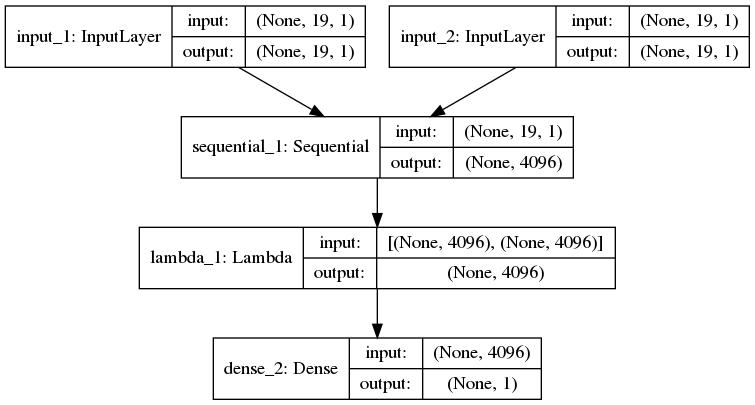

In [13]:
plot_model(model, show_shapes=True, show_layer_names=True)

In [14]:
optimizer = Adam(6e-5)
model.compile(loss="binary_crossentropy", optimizer=optimizer)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [15]:
def get_batch_1(dict_, categories, batch_size):
    
    categories_batch = np.random.choice(categories, batch_size)
#     print(categories_batch)
    
#     First half use same class
    division_point = int(batch_size / 2)
    
    batch_1 = np.zeros((batch_size, data_length, 1))
    batch_2 = np.zeros((batch_size, data_length, 1))

    label = np.zeros((batch_size,))
    
    for i in range(batch_size):
        data_temp = dict_[categories_batch[i]]
        if i <= division_point:
            data_batch = data_temp[np.random.choice(data_temp.shape[0], 2, replace=True)]
            batch_1[i,:,:] = data_batch[0].reshape(data_length,1)
            batch_2[i,:,:] = data_batch[1].reshape(data_length,1)
            label[i] = 1
        else:
            categories_temp = categories.copy()
            categories_temp.remove(categories_batch[i])
            batch_1[i,:,:] = data_temp[rd.randint(0, len(data_temp) - 1)]
            data_temp_2 = dict_[rd.sample(categories_temp, 1)[0]]
            batch_2[i,:,:] = data_temp_2[np.random.choice(data_temp_2.shape[0], 1, replace=True)]
            
#     print(batch_1.shape, batch_2.shape)
    batch_1, batch_2, label = shuffle(batch_1, batch_2, label)
    return batch_1, batch_2, label

In [16]:
test_class_index = 0

def get_batch_test(dict_, categories, N, test_class_sequential = False):
    
    global test_class_index
#     print(categories)
    categories_batch = rd.sample(categories, N)
#     print(categories_batch)
    
    if test_class_sequential == True:
        #print("<==========Sequential Test==========>")
        categories_temp = categories.copy()
        categories_temp.remove(categories[test_class_index])
        categories_batch[0] = categories[test_class_index]
        categories_batch[1:] = rd.sample(categories_temp, N - 1)
#         print(categories_batch)
        if test_class_index == int(len(categories) - 1):
            test_class_index = 0
            #print("<==========Sequential Test END==========>")
        else:
            test_class_index += 1
    
    test_data = dict_[categories_batch[0]]
    test_sample = test_data[np.random.choice(test_data.shape[0], 2, replace=True)]
    
    test_sample_copies = np.zeros((N, data_length, 1))
    support_set = np.zeros((N, data_length, 1))
    
    test_sample_copies[0,:,:] = test_sample[0]
    support_set[0,:,:] = test_sample[1]
    
    label = np.zeros((N,))
    label[0,] = 1
    
    for i in range(1, N):
#         print(i, len(dict_[categories_batch[i]]))
        support_data = dict_[categories_batch[i]]
        support_set[i,:,:] = support_data[np.random.choice(support_data.shape[0], 1, replace=True)]
        test_sample_copies[i,:,:] = test_sample[0].copy()
            
#     print(test_image.shape, support_set.shape)
    test_image_copies, support_set, label = shuffle(test_sample_copies, support_set, label)
    return test_image_copies, support_set, label

In [17]:
def test(model, dict_, categories, N, test_num, test_class_sequential = False):
    correct_num = 0
    print("Use " + str(N) + " way one-shot learning on " + str(test_num) + " test sets.")
    
    for i in range(test_num):
        test_image_copies, support_set, label = get_batch_test(dict_, categories, N, test_class_sequential)
        probs = model.predict([test_image_copies, support_set])
#         print(probs)
        if np.argmax(probs) == np.argmax(label):
        
#             print("Bingo!!!")
            correct_num += 1
#         else:
#             print("Ah-oh...")
    accuracy = 1.0 * correct_num / test_num
    print("Accuracy is " + str(accuracy))
    return accuracy

In [18]:
# Hyper parameters
evaluate_every = 10 # interval for evaluating on one-shot tasks
batch_size = 16
n_iter = 2000 # No. of training iterations
N_way = 8 # how many classes for testing one-shot tasks
n_val = 200 # how many one-shot tasks to validate on
best = -1

In [19]:
print("Starting training process!")
print("-------------------------------------")
t_start = time.time()
train_result = {
    'iter_num':[],
    'accuracy':[],
    'loss':[]
}

# model.reset_states()

for i in range(1, n_iter+1):
    batch_1, batch_2, label = get_batch_1(train_dict, categories, batch_size)
    loss = model.train_on_batch([batch_1, batch_2], label)
    if i % evaluate_every == 0:
        print("\n ------------- \n")
        print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
        print("Train Loss: {0}".format(loss)) 
        val_acc = test(model, test_dict, categories, N_way, n_val)
        #model.save_weights(os.path.join(model_path, 'weights.{}.h5'.format(i)))
        print("Current best: {0}, previous best: {1}".format(val_acc, best))
#         accurracy.append((i, val_acc))
        train_result['iter_num'].append(i)
        train_result['accuracy'].append(val_acc)
        train_result['loss'].append(loss)
        if val_acc >= best:
            best = val_acc
            
# from keras.models import load_model
# model.save('siamese_'+str(best)+'.h5')  # creates a HDF5 file 'my_model.h5'

Starting training process!
-------------------------------------


 ------------- 

Time for 10 iterations: 0.013698418935139975 mins
Train Loss: 0.7738513350486755
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.3
Current best: 0.3, previous best: -1

 ------------- 

Time for 20 iterations: 0.01982478698094686 mins
Train Loss: 0.5678308010101318
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.32
Current best: 0.32, previous best: 0.3

 ------------- 

Time for 30 iterations: 0.025447213649749757 mins
Train Loss: 0.6386256814002991
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.37
Current best: 0.37, previous best: 0.32

 ------------- 

Time for 40 iterations: 0.030771756172180177 mins
Train Loss: 0.6728739142417908
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.345
Current best: 0.345, previous best: 0.37

 ------------- 

Time for 50 iterations: 0.03615802526473999 mins
Train Loss: 0.673040509223938
Use 8 way one-shot learning on 20

Accuracy is 0.44
Current best: 0.44, previous best: 0.43

 ------------- 

Time for 410 iterations: 0.2385833144187927 mins
Train Loss: 0.4802595376968384
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.285
Current best: 0.285, previous best: 0.44

 ------------- 

Time for 420 iterations: 0.24437585671742756 mins
Train Loss: 0.24462692439556122
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.39
Current best: 0.39, previous best: 0.44

 ------------- 

Time for 430 iterations: 0.2500524163246155 mins
Train Loss: 0.5298629403114319
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.34
Current best: 0.34, previous best: 0.44

 ------------- 

Time for 440 iterations: 0.25579601923624673 mins
Train Loss: 0.4569045603275299
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.38
Current best: 0.38, previous best: 0.44

 ------------- 

Time for 450 iterations: 0.2614358186721802 mins
Train Loss: 0.5853057503700256
Use 8 way one-shot learning on 200 t

Accuracy is 0.375
Current best: 0.375, previous best: 0.44

 ------------- 

Time for 820 iterations: 0.4662943204243978 mins
Train Loss: 0.30703940987586975
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.325
Current best: 0.325, previous best: 0.44

 ------------- 

Time for 830 iterations: 0.47170725266138713 mins
Train Loss: 0.7166854739189148
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.325
Current best: 0.325, previous best: 0.44

 ------------- 

Time for 840 iterations: 0.47704376379648844 mins
Train Loss: 0.35972079634666443
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.36
Current best: 0.36, previous best: 0.44

 ------------- 

Time for 850 iterations: 0.48254595200220746 mins
Train Loss: 0.8934884667396545
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.33
Current best: 0.33, previous best: 0.44

 ------------- 

Time for 860 iterations: 0.4880891919136047 mins
Train Loss: 0.4909150004386902
Use 8 way one-shot learning on

Accuracy is 0.355
Current best: 0.355, previous best: 0.44

 ------------- 

Time for 1230 iterations: 0.7040241161982218 mins
Train Loss: 0.42996853590011597
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.365
Current best: 0.365, previous best: 0.44

 ------------- 

Time for 1240 iterations: 0.7099001248677571 mins
Train Loss: 0.3684958815574646
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.335
Current best: 0.335, previous best: 0.44

 ------------- 

Time for 1250 iterations: 0.716508416334788 mins
Train Loss: 0.182610422372818
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.395
Current best: 0.395, previous best: 0.44

 ------------- 

Time for 1260 iterations: 0.722904113928477 mins
Train Loss: 0.5093711018562317
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.375
Current best: 0.375, previous best: 0.44

 ------------- 

Time for 1270 iterations: 0.7296306173006694 mins
Train Loss: 0.5282943844795227
Use 8 way one-shot learning 

Accuracy is 0.345
Current best: 0.345, previous best: 0.445

 ------------- 

Time for 1640 iterations: 0.9333938757578532 mins
Train Loss: 0.4880487322807312
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.37
Current best: 0.37, previous best: 0.445

 ------------- 

Time for 1650 iterations: 0.9387544711430867 mins
Train Loss: 0.3228685259819031
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.4
Current best: 0.4, previous best: 0.445

 ------------- 

Time for 1660 iterations: 0.9444590926170349 mins
Train Loss: 0.34035801887512207
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.385
Current best: 0.385, previous best: 0.445

 ------------- 

Time for 1670 iterations: 0.9502076903978983 mins
Train Loss: 0.34030526876449585
Use 8 way one-shot learning on 200 test sets.
Accuracy is 0.355
Current best: 0.355, previous best: 0.445

 ------------- 

Time for 1680 iterations: 0.9559536616007487 mins
Train Loss: 0.43985599279403687
Use 8 way one-shot learn

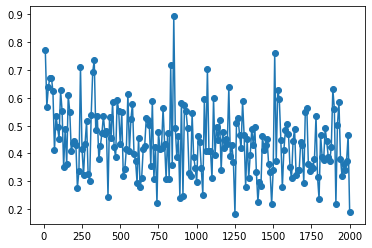

In [20]:
plt.plot(train_result['iter_num'], train_result['loss'], marker='o')

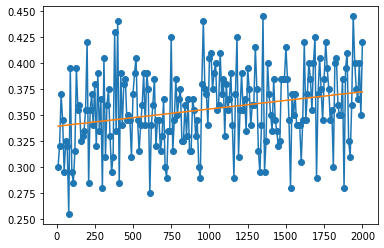

In [21]:
from sklearn.linear_model import LinearRegression

model_lr = LinearRegression().fit(np.array(train_result['iter_num']).reshape(-1, 1), \
                                  np.array(train_result['accuracy']).reshape(-1, 1))

lr_y = model_lr.coef_ * np.array(train_result['iter_num']).reshape(-1, 1) +  model_lr.intercept_
plt.plot(train_result['iter_num'], train_result['accuracy'], marker='o')
plt.plot(train_result['iter_num'], lr_y)

In [22]:
np.mean(train_result['accuracy'])

0.35590000000000005


 ------------- 

Use 1 way one-shot learning on 2000 test sets.
Accuracy is 1.0
Accuracy is 

 ------------- 

Use 2 way one-shot learning on 2000 test sets.
Accuracy is 0.7705
Accuracy is 

 ------------- 

Use 3 way one-shot learning on 2000 test sets.
Accuracy is 0.646
Accuracy is 

 ------------- 

Use 4 way one-shot learning on 2000 test sets.
Accuracy is 0.5525
Accuracy is 

 ------------- 

Use 5 way one-shot learning on 2000 test sets.
Accuracy is 0.4765
Accuracy is 

 ------------- 

Use 6 way one-shot learning on 2000 test sets.
Accuracy is 0.4165
Accuracy is 

 ------------- 

Use 7 way one-shot learning on 2000 test sets.
Accuracy is 0.3995
Accuracy is 

 ------------- 

Use 8 way one-shot learning on 2000 test sets.
Accuracy is 0.3575
Accuracy is 


0.577375

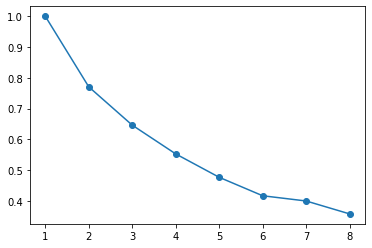

In [23]:
test_result = {
    'N_way':[],
    'accuracy':[],
}
n_iter = 1
N_ways = [i for i in range(1, 9)] # how many classes for testing one-shot tasks
n_val = 2000 # how many one-shot tasks to validate on
# best = -1


for i in range(1, n_iter+1):
    for N_way in N_ways:
        print("\n ------------- \n")
#         print("Time for {0} iterations: {1} mins".format(i, (time.time()-t_start)/60.0))
#         print("Train Loss: {0}".format(loss)) 
        test_acc = test(model, test_dict, categories, N_way, n_val)
        print("Accuracy is ".format(test_acc))
        test_result['N_way'].append(N_way)
        test_result['accuracy'].append(test_acc)

plt.plot(test_result['N_way'], test_result['accuracy'], marker='o')
np.mean(test_result['accuracy'])

In [24]:
test_result['accuracy']

[1.0, 0.7705, 0.646, 0.5525, 0.4765, 0.4165, 0.3995, 0.3575]

### Baseline model based on Nearest Neighbors using Euclidean distance (L2 distance)

In [ ]:
def nearest_neighbour_correct(pairs,targets):
    """returns 1 if nearest neighbour gets the correct answer for a one-shot task
        given by (pairs, targets)"""
    L2_distances = np.zeros_like(targets)
    for i in range(len(targets)):
        L2_distances[i] = np.sum(np.sqrt(pairs[0][i]**2 - pairs[1][i]**2))
    if np.argmin(L2_distances) == np.argmax(targets):
        return 1
    return 0

In [ ]:
def test_nn_accuracy(N_ways,n_trials):
    """Returns accuracy of NN approach """
    print("Evaluating nearest neighbour on {} unique {} way one-shot learning tasks ...".format(n_trials,N_ways))

    n_right = 0
    
    for i in range(n_trials):
        test_image_copies, support_set, label = get_batch_test(test_dict, test_categories, N_ways)
        correct = nearest_neighbour_correct([test_image_copies, support_set], label)
        n_right += correct
    return 1.0 * n_right / n_trials

In [ ]:
ways = np.arange(1,21,1)
resume =  False
trials = 200

In [ ]:
val_accs, train_accs,nn_accs = [], [], []
for N in ways:    
#     val_accs.append(test_oneshot(model, N, trials, "val", verbose=True))
#     train_accs.append(test_oneshot(model, N, trials, "train", verbose=True))
    nn_acc = test_nn_accuracy(N, trials)
    nn_accs.append(nn_acc)
    print ("NN Accuracy = ", nn_acc)
    print("---------------------------------------------------------------------------------------------------------------")

In [ ]:
fig, ax = plt.subplots(figsize=(20, 10))
ax.plot(N_ways, test_result['accuracy'], "r", label="Siamese Network (test set)")
ax.plot(N_ways, test_result_train['accuracy'], "y", label="Siamese Network (train set)")
plt.plot(N_ways, nn_accs, label="Nearest neighbour (test set)")
plt.xticks(N_ways, fontsize = 22) 
plt.yticks(fontsize = 22)
ax.plot(N_ways, 1.0/ways, "g", label="Random guessing")
plt.xlabel("N-way Classification", fontsize = 22)
plt.ylabel("Accuracy", fontsize = 22)
plt.title("Siamese Network on Caltech 101", fontsize =22)
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])
ax.legend(fontsize = 22)
# inputs,targets = make_oneshot_task(20, "val", 'Oriya')
plt.show()

# plot_oneshot_task(inputs)